In [1]:
!pip install diffusers

# Effective and efficient diffusion

Getting the [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline) to generate images in a certain style or include what you want can be tricky. Often times, you have to run the [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline) several times before you end up with an image you're happy with. But generating something out of nothing is a computationally intensive process, especially if you're running inference over and over again.

This is why it's important to get the most *computational* (speed) and *memory* (GPU RAM) efficiency from the pipeline to reduce the time between inference cycles so you can iterate faster.

This tutorial walks you through how to generate faster and better with the [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline).

Begin by loading the [`runwayml/stable-diffusion-v1-5`](https://huggingface.co/runwayml/stable-diffusion-v1-5) model:

In [2]:
from diffusers import DiffusionPipeline

model_id = "runwayml/stable-diffusion-v1-5"
pipeline = DiffusionPipeline.from_pretrained(model_id)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The example prompt you'll use is a portrait of an old warrior chief, but feel free to use your own prompt:

In [3]:
prompt = "Brock lesnar as a ballerina"

## Speed

<Tip>

💡 If you don't have access to a GPU, you can use one for free from a GPU provider like [Colab](https://colab.research.google.com/)!

</Tip>

One of the simplest ways to speed up inference is to place the pipeline on a GPU the same way you would with any PyTorch module:

In [4]:
pipeline = pipeline.to("cuda")

To make sure you can use the same image and improve on it, use a [`Generator`](https://pytorch.org/docs/stable/generated/torch.Generator.html) and set a seed for [reproducibility](https://huggingface.co/docs/diffusers/main/en/./using-diffusers/reproducibility):

In [5]:
import torch

generator = torch.Generator("cuda").manual_seed(0)

Now you can generate an image:

  0%|          | 0/50 [00:00<?, ?it/s]

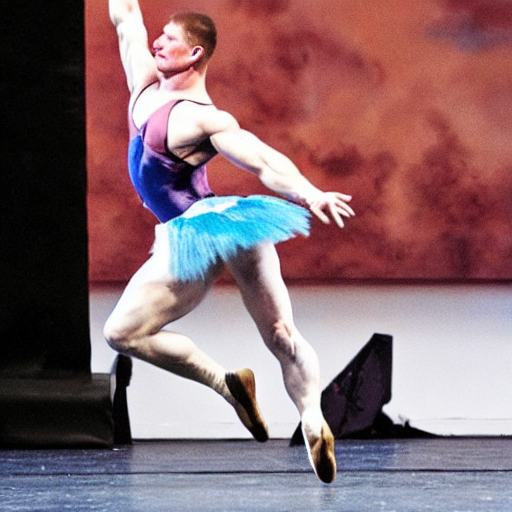

In [6]:
image = pipeline(prompt, generator=generator).images[0]
image

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/diffusers/docs-images/resolve/main/stable_diffusion_101/sd_101_1.png">
</div>

This process took ~30 seconds on a T4 GPU (it might be faster if your allocated GPU is better than a T4). By default, the [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline) runs inference with full `float32` precision for 50 inference steps. You can speed this up by switching to a lower precision like `float16` or running fewer inference steps.

Let's start by loading the model in `float16` and generate an image:

In [ ]:
import torch

pipeline = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")
generator = torch.Generator("cuda").manual_seed(0)
image = pipeline(prompt, generator=generator).images[0]
image

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/diffusers/docs-images/resolve/main/stable_diffusion_101/sd_101_2.png">
</div>

This time, it only took ~11 seconds to generate the image, which is almost 3x faster than before!

<Tip>

💡 We strongly suggest always running your pipelines in `float16`, and so far, we've rarely seen any degradation in output quality.

</Tip>

Another option is to reduce the number of inference steps. Choosing a more efficient scheduler could help decrease the number of steps without sacrificing output quality. You can find which schedulers are compatible with the current model in the [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline) by calling the `compatibles` method:

In [ ]:
pipeline.scheduler.compatibles
[
    diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
    diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
    diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
    diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
    diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
    diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
    diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
    diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
    diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
    diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
    diffusers.schedulers.scheduling_pndm.PNDMScheduler,
    diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
    diffusers.schedulers.scheduling_ddim.DDIMScheduler,
]

The Stable Diffusion model uses the [PNDMScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/pndm#diffusers.PNDMScheduler) by default which usually requires ~50 inference steps, but more performant schedulers like [DPMSolverMultistepScheduler](https://huggingface.co/docs/diffusers/main/en/api/schedulers/multistep_dpm_solver#diffusers.DPMSolverMultistepScheduler), require only ~20 or 25 inference steps. Use the [ConfigMixin.from_config()](https://huggingface.co/docs/diffusers/main/en/api/configuration#diffusers.ConfigMixin.from_config) method to load a new scheduler:

In [ ]:
from diffusers import DPMSolverMultistepScheduler

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)

Now set the `num_inference_steps` to 20:

In [ ]:
generator = torch.Generator("cuda").manual_seed(0)
image = pipeline(prompt, generator=generator, num_inference_steps=20).images[0]
image

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/diffusers/docs-images/resolve/main/stable_diffusion_101/sd_101_3.png">
</div>

Great, you've managed to cut the inference time to just 4 seconds! ⚡️

## Memory

The other key to improving pipeline performance is consuming less memory, which indirectly implies more speed, since you're often trying to maximize the number of images generated per second. The easiest way to see how many images you can generate at once is to try out different batch sizes until you get an `OutOfMemoryError` (OOM).

Create a function that'll generate a batch of images from a list of prompts and `Generators`. Make sure to assign each `Generator` a seed so you can reuse it if it produces a good result.

In [ ]:
def get_inputs(batch_size=1):
    generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 20

    return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

You'll also need a function that'll display each batch of images:

In [ ]:
from PIL import Image


def image_grid(imgs, rows=2, cols=2):
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

Start with `batch_size=4` and see how much memory you've consumed:

In [ ]:
images = pipeline(**get_inputs(batch_size=4)).images
image_grid(images)

Unless you have a GPU with more RAM, the code above probably returned an `OOM` error! Most of the memory is taken up by the cross-attention layers. Instead of running this operation in a batch, you can run it sequentially to save a significant amount of memory. All you have to do is configure the pipeline to use the [enable_attention_slicing()](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/upscale#diffusers.StableDiffusionUpscalePipeline.enable_attention_slicing) function:

In [ ]:
pipeline.enable_attention_slicing()

Now try increasing the `batch_size` to 8!

In [ ]:
images = pipeline(**get_inputs(batch_size=8)).images
image_grid(images, rows=2, cols=4)

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/diffusers/docs-images/resolve/main/stable_diffusion_101/sd_101_5.png">
</div>

Whereas before you couldn't even generate a batch of 4 images, now you can generate a batch of 8 images at ~3.5 seconds per image! This is probably the fastest you can go on a T4 GPU without sacrificing quality.

## Quality

In the last two sections, you learned how to optimize the speed of your pipeline by using `fp16`, reducing the number of inference steps by using a more performant scheduler, and enabling attention slicing to reduce memory consumption. Now you're going to focus on how to improve the quality of generated images.

### Better checkpoints

The most obvious step is to use better checkpoints. The Stable Diffusion model is a good starting point, and since its official launch, several improved versions have also been released. However, using a newer version doesn't automatically mean you'll get better results. You'll still have to experiment with different checkpoints yourself, and do a little research (such as using [negative prompts](https://minimaxir.com/2022/11/stable-diffusion-negative-prompt/)) to get the best results.

As the field grows, there are more and more high-quality checkpoints finetuned to produce certain styles. Try exploring the [Hub](https://huggingface.co/models?library=diffusers&sort=downloads) and [Diffusers Gallery](https://huggingface.co/spaces/huggingface-projects/diffusers-gallery) to find one you're interested in!

### Better pipeline components

You can also try replacing the current pipeline components with a newer version. Let's try loading the latest [autodecoder](https://huggingface.co/stabilityai/stable-diffusion-2-1/tree/main/vae) from Stability AI into the pipeline, and generate some images:

In [ ]:
from diffusers import AutoencoderKL

vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")
pipeline.vae = vae
images = pipeline(**get_inputs(batch_size=8)).images
image_grid(images, rows=2, cols=4)

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/diffusers/docs-images/resolve/main/stable_diffusion_101/sd_101_6.png">
</div>

### Better prompt engineering

The text prompt you use to generate an image is super important, so much so that it is called *prompt engineering*. Some considerations to keep during prompt engineering are:

- How is the image or similar images of the one I want to generate stored on the internet?
- What additional detail can I give that steers the model towards the style I want?

With this in mind, let's improve the prompt to include color and higher quality details:

In [ ]:
prompt += ", tribal panther make up, blue on red, side profile, looking away, serious eyes"
prompt += " 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta"

Generate a batch of images with the new prompt:

In [ ]:
images = pipeline(**get_inputs(batch_size=8)).images
image_grid(images, rows=2, cols=4)

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/diffusers/docs-images/resolve/main/stable_diffusion_101/sd_101_7.png">
</div>

Pretty impressive! Let's tweak the second image - corresponding to the `Generator` with a seed of `1` - a bit more by adding some text about the age of the subject:

In [ ]:
prompts = [
    "portrait photo of the oldest warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a old warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
    "portrait photo of a young warrior chief, tribal panther make up, blue on red, side profile, looking away, serious eyes 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta",
]

generator = [torch.Generator("cuda").manual_seed(1) for _ in range(len(prompts))]
images = pipeline(prompt=prompts, generator=generator, num_inference_steps=25).images
image_grid(images)

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/diffusers/docs-images/resolve/main/stable_diffusion_101/sd_101_8.png">
</div>

## Next steps

In this tutorial, you learned how to optimize a [DiffusionPipeline](https://huggingface.co/docs/diffusers/main/en/api/pipelines/overview#diffusers.DiffusionPipeline) for computational and memory efficiency as well as improving the quality of generated outputs. If you're interested in making your pipeline even faster, take a look at the following resources:

- Learn how [PyTorch 2.0](https://huggingface.co/docs/diffusers/main/en/./optimization/torch2.0) and [`torch.compile`](https://pytorch.org/docs/stable/generated/torch.compile.html) can yield 5 - 300% faster inference speed. On an A100 GPU, inference can be up to 50% faster!
- If you can't use PyTorch 2, we recommend you install [xFormers](https://huggingface.co/docs/diffusers/main/en/./optimization/xformers). Its memory-efficient attention mechanism works great with PyTorch 1.13.1 for faster speed and reduced memory consumption.
- Other optimization techniques, such as model offloading, are covered in [this guide](https://huggingface.co/docs/diffusers/main/en/./optimization/fp16).